In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
import pymc as pm
from properscoring import crps_ensemble
import random
from patsy import dmatrix
import arviz as az
import matplotlib.pyplot as plt



sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SeroDataset, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SparsePropTrain, SeroTrain
from model_tools.models import NowcastPNN, PropPNN, SparsePropPNN, SeroPNN
from model_tools.evaluation import eval_pnn, eval_prop_pnn, eval_sparse_prop_pnn, eval_sero_pnn, plot_pnn_preds, plot_prop_pnn_preds, plot_sero_pnn_preds

M = 100
D = 40

start_year = 2022
end_year = 2022
seed = 123

# 123, 2019, 2023, 15

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




In [2]:
# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M, norm=False)
true_count_dataset = TrueCountDataset(delays_df)


In [3]:
# End of 2023 appears to have some incomplete data
if end_year == 2023:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
else:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-31", freq='D'))

In [4]:
dates

[Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2022-01-03 00:00:00'),
 Timestamp('2022-01-04 00:00:00'),
 Timestamp('2022-01-05 00:00:00'),
 Timestamp('2022-01-06 00:00:00'),
 Timestamp('2022-01-07 00:00:00'),
 Timestamp('2022-01-08 00:00:00'),
 Timestamp('2022-01-09 00:00:00'),
 Timestamp('2022-01-10 00:00:00'),
 Timestamp('2022-01-11 00:00:00'),
 Timestamp('2022-01-12 00:00:00'),
 Timestamp('2022-01-13 00:00:00'),
 Timestamp('2022-01-14 00:00:00'),
 Timestamp('2022-01-15 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 Timestamp('2022-01-17 00:00:00'),
 Timestamp('2022-01-18 00:00:00'),
 Timestamp('2022-01-19 00:00:00'),
 Timestamp('2022-01-20 00:00:00'),
 Timestamp('2022-01-21 00:00:00'),
 Timestamp('2022-01-22 00:00:00'),
 Timestamp('2022-01-23 00:00:00'),
 Timestamp('2022-01-24 00:00:00'),
 Timestamp('2022-01-25 00:00:00'),
 Timestamp('2022-01-26 00:00:00'),
 Timestamp('2022-01-27 00:00:00'),
 Timestamp('2022-01-28 00:00:00'),
 Timestamp('2022-01-

In [5]:
class PropBNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        window_dates = [date - pd.Timedelta(days=i) for i in range(M)]
        window_dates = sorted(window_dates)
        Z_obs = self.partial_count_obj.get_obs(date)
        y_true = [self.true_count_obj.get_y(day) for day in window_dates]
        y_true = np.array(y_true).reshape(M)
        dow = date.day_of_week
        return Z_obs, y_true, window_dates

set_seed(seed)
dataset = PropBNNDataset(partial_count_dataset, true_count_dataset, dates)




In [6]:
def silu(x):
    return x * pm.math.sigmoid(x)


def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        cores=1,
        init="adapt_diag",
        chains=1,
        draws=500,
        tune=500,
        target_accept=0.95,
        max_treedepth=10,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}
    )

def get_mask(D):
        mask_matrix = np.ones(shape=(D, D), dtype=bool)
        for i in range(D):
            for j in range(D):
                if i + j > D - 1:
                    mask_matrix[i, j] = False
        return mask_matrix

def create_fourier_features(t, n, p=10.0):
    x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)


In [7]:
Z_obs, y_true, window_dates = dataset.__getitem__(2)

# Constants
t = np.arange(0, M)
t_week = t % 7
t_norm = t / M

n = 14
fourier_basis_biweek = create_fourier_features(t, n=n, p=3.5)
fourier_basis_week = create_fourier_features(t, n=n, p=7)

spline_trend = dmatrix(
    "bs(t, df=14, degree=3, include_intercept=False)", {"t": t_norm}, return_type='dataframe'
)
X_trend = np.asarray(spline_trend)

spline_week = dmatrix(
    "cc(t_week, df=6)", {"t_week": t_week}, return_type='dataframe'
)
X_week = np.asarray(spline_week)

t_input = np.arange(M)[:, None] / M
time_input = np.concatenate([t_input, fourier_basis_biweek, fourier_basis_week], axis=1)

Z_norm = Z_obs / Z_obs.max()
Z_flat = Z_norm.reshape((1,M*D)) 


In [8]:
mask = np.ones_like(Z_obs, dtype=bool)
mask[-D:,:] = get_mask(D)
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])

In [25]:
with pm.Model() as model:
    const=10000



     # Trend spline coefficients
    sigma_trend = pm.HalfNormal("sigma_trend", 3)
    beta_trend = pm.Normal("beta_trend", mu=0, sigma=sigma_trend, shape=X_trend.shape[1])
    
    # Cyclic spline coefficients (seasonality)
    sigma_week = pm.HalfNormal("sigma_week", 3)
    beta_week = pm.Normal("beta_week", mu=0, sigma=sigma_week, shape=X_week.shape[1])
    
    init_dist = pm.Normal.dist(mu=0, sigma=10)
    sigma_rw = pm.HalfNormal("sigma_rw", 3)
    rw = pm.GaussianRandomWalk("log_lambda", sigma=sigma_rw, shape=M, init_dist=init_dist)

    log_lam = pm.Deterministic(
            "log_lam", rw + pm.math.dot(X_trend, beta_trend) + pm.math.dot(X_week, beta_week)
        )
    
    

    lam = pm.Deterministic("lam", const*pm.math.exp(log_lam))

    # NN for proportions
    t = np.arange(M)[:, None] / M
    time_input = np.concatenate([t, fourier_basis_biweek, fourier_basis_week], axis=1)
    n_hidden = 16
    net_sd = 0.1
    
    W1 = pm.Normal("W1", 0, net_sd, shape=(1+4*n, n_hidden))
    b1 = pm.Normal("b1", 0, net_sd, shape=(n_hidden,))
    h1 = silu(pm.math.dot(time_input, W1) + b1)
    
    # ----- Output layer: hidden → delay bins -----
    W2 = pm.Normal("W2", 0, net_sd, shape=(n_hidden, D))
    b2 = pm.Normal("b2", 0, net_sd, shape=(D,))
    p_raw = pm.math.dot(h1, W2) + b2
    

    p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=1))

    # p = pm.Dirichlet("p", a=np.ones(D), shape=(D))


    log_mu = pm.math.log(lam[:, None]) + pm.math.log(p + 1e-6)
    mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    
    alpha = pm.Exponential("alpha", 3)
    z = pm.NegativeBinomial("z", mu[mask], alpha, observed=Z_obs[mask])
    
    idata = pm.sample(progressbar=True, **sampler_kwargs())


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1000,0,0.05,127


In [26]:
mu_post_samples = az.extract(idata, group='posterior', num_samples=1000)['mu']
lam_post_samples = mu_post_samples.sum('mu_dim_1')

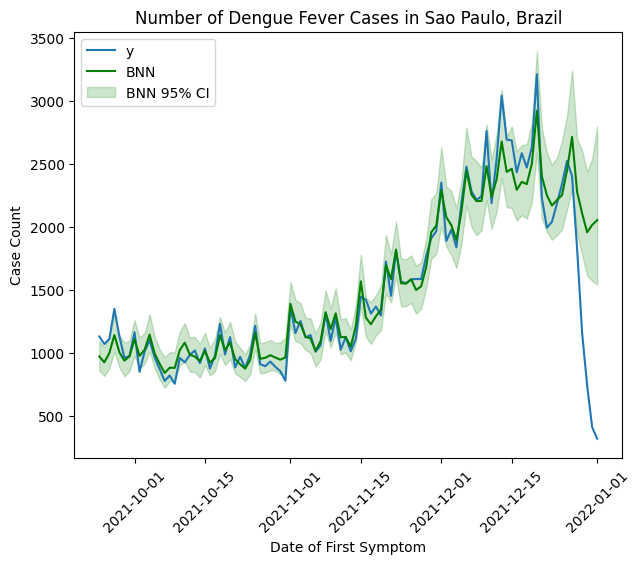

In [27]:
lam_post_med = np.quantile(lam_post_samples, 0.5, axis=1)
lam_post_lower = np.quantile(lam_post_samples, 0.025, axis=1)
lam_post_upper = np.quantile(lam_post_samples, 0.975, axis=1)

plt.plot(window_dates, y_true, label='y')

plt.plot(window_dates, lam_post_med, label='BNN', color='green')
plt.fill_between(window_dates, lam_post_lower, lam_post_upper, color='green', alpha=0.2, label='BNN 95% CI')


plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
mu_post_samples = az.extract(idata, group='posterior', num_samples=1000)['p']
mu_post_samples.mean("sample")[:, 0]

<xarray.DataArray 'p' (p_dim_0: 100)> Size: 800B
array([0.08059224, 0.11323567, 0.12510597, 0.12755085, 0.13333942,
       0.10974831, 0.08972091, 0.08088027, 0.11371985, 0.12568947,
       0.12824658, 0.13409038, 0.11036584, 0.09008298, 0.08115611,
       0.11418699, 0.12625352, 0.12892395, 0.1348234 , 0.11096775,
       0.09043311, 0.08141997, 0.11463732, 0.12679836, 0.12958308,
       0.1355386 , 0.11155422, 0.09077149, 0.08167207, 0.11507108,
       0.12732423, 0.13022407, 0.13623616, 0.11212542, 0.09109831,
       0.08191262, 0.1154885 , 0.12783135, 0.13084707, 0.13691623,
       0.11268154, 0.09141378, 0.08214185, 0.11588983, 0.12832   ,
       0.13145223, 0.137579  , 0.1132228 , 0.09171808, 0.08235999,
       0.11627535, 0.12879043, 0.1320397 , 0.13822464, 0.11374939,
       0.09201143, 0.08256727, 0.1166453 , 0.12924293, 0.13260967,
       0.13885335, 0.11426153, 0.09229403, 0.08276392, 0.11699995,
       0.12967776, 0.13316231, 0.13946533, 0.11475944, 0.0925661 ,
       0.08295018, 0.11733958, 0.13009522, 0.1336978 , 0.14006078,
       0.11524333, 0.09282783, 0.08312628, 0.11766445, 0.13049559,
       0.13421636, 0.1406399 , 0.11571344, 0.09307945, 0.08329246,
       0.11797485, 0.13087917, 0.13471819, 0.14120293, 0.11616999,
       0.09332116, 0.08344896, 0.11827104, 0.13124626, 0.13520349,
       0.14175006, 0.11661321, 0.09355318, 0.083596  , 0.11855331])
Coordinates:
  * p_dim_0  (p_dim_0) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
    p_dim_1  int64 8B 0

In [16]:

with pm.Model() as model:
    Z_obs_shared = pm.Data("Z_obs_shared", Z_obs[mask])

    const=10000
    # Trend spline coefficients
    sigma_trend = pm.HalfNormal("sigma_trend", 3)
    beta_trend = pm.Normal("beta_trend", mu=0, sigma=sigma_trend, shape=X_trend.shape[1])
    
    # Cyclic spline coefficients (seasonality)
    sigma_week = pm.HalfNormal("sigma_week", 3)
    beta_week = pm.Normal("beta_week", mu=0, sigma=sigma_week, shape=X_week.shape[1])
    
    log_lam = pm.Deterministic(
            "log_lam", pm.math.dot(X_trend, beta_trend) + pm.math.dot(X_week, beta_week)
        )
    lam = pm.Deterministic("lam", const*pm.math.exp(log_lam))

    # NN for proportions
    
    n_hidden = 16
    net_sd = 0.1
    
    W1 = pm.Normal("W1", 0, net_sd, shape=(1+4*n, n_hidden))
    b1 = pm.Normal("b1", 0, net_sd, shape=(n_hidden,))
    h1 = silu(pm.math.dot(time_input, W1) + b1)
    
    # ----- Output layer: hidden → delay bins -----
    W2 = pm.Normal("W2", 0, net_sd, shape=(n_hidden, D))
    b2 = pm.Normal("b2", 0, net_sd, shape=(D,))
    p_raw = pm.math.dot(h1, W2) + b2
    

    p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=1))


    log_mu = pm.math.log(lam[:, None]) + pm.math.log(p + 1e-6)
    mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    sigma_theta = pm.HalfNormal("sigma_theta", 1)
    theta = pm.Exponential("theta", lam=1/sigma_theta, shape=(M,1))
    theta_broadcast = np.repeat(theta, D, axis=1)

    z = pm.NegativeBinomial("z", mu[mask], theta_broadcast[mask], observed=Z_obs_shared)
    





In [17]:
Z_obs, y_true, window_dates = dataset.__getitem__(0)
with model:
    pm.set_data({"Z_obs_shared": Z_obs[mask]})
    idata = pm.sample(progressbar=True, **sampler_kwargs())


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1000,0,0.04,127


In [ ]:
Z_obs, y_true, window_dates = dataset.__getitem__(1)
with model:
    pm.set_data({"Z_obs_shared": Z_obs[mask]})
    idata = pm.sample(progressbar=True, **sampler_kwargs())

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1000,0,0.05,127


In [ ]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=[""])


Sampling: [z]


Output()

In [ ]:
posterior_predictive.posterior_predictive["z"].shape

(1, 500, 3220)